In [1]:
# using Google CoLab as my coding environment 
# checking the GPU 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# data normalization
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y


# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

print("The shape of x_train", x_train.shape)
print("The shape of y_train", y_train.shape)
print("The shape of x_test", x_test.shape)
print("The shape of y_test", y_test.shape)

Using TensorFlow backend.


170500096/170498071 [==============================] - 15s 0us/step
The shape of x_train (50000, 3072)
The shape of y_train (50000, 10)
The shape of x_test (10000, 3072)
The shape of y_test (10000, 10)


In [0]:
# hyperparameters
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 1024
DROPOUT = 0.1
MOMENTUM = 0.95

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling2D, MaxPool2D, BatchNormalization,AveragePooling2D, Dropout

# construction a model with dropout layer
def build_mlp(input_shape, output_units=10,DROPOUT=0.1):
    input_layer = keras.layers.Input(input_shape)
    model = Sequential()
    
    # layer 1
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))
    
    # layer 2
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))
    
    # layer 3
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))
    
    # layer 4
    model.add(Dense(10))
    model.add(Activation('softmax'))

    return model

In [0]:
# define a specific loss function 
import tensorflow as tf
import keras.backend as K


def combined_loss(ce_weights = 1,):

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        gamma, alpha = 2,4
        
        gamma = float(gamma)
        alpha = float(alpha)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        return tf.reduce_mean(reduced_fl)*(1-ce_weights)+  ce_weights*ce
     
    
    return focal_loss_fixed

In [6]:
import itertools
results = {}
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    # model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss=combined_loss(ce_weights =ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-ce_weights_%s" % (ce_w))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0806 00:44:53.554577 140634644952960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 00:44:53.559942 140634644952960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 00:44:53.586535 140634644952960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 00:44:53.592118 140634644952960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 00:44:53.699937 140634644952960 deprecation_wrappe

Numbers of exp: 0, ce_weight: 0.00


W0806 00:44:54.339851 140634644952960 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0806 00:44:54.948350 140634644952960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 6s 111us/step - loss: 6.4170 - acc: 0.2772 - val_loss: 5.5633 - val_acc: 0.3477
Epoch 2/100
50000/50000 [==============================] - 2s 40us/step - loss: 4.9340 - acc: 0.3867 - val_loss: 4.7416 - val_acc: 0.4005
Epoch 3/100
50000/50000 [==============================] - 2s 39us/step - loss: 4.5230 - acc: 0.4207 - val_loss: 4.4827 - val_acc: 0.4271
Epoch 4/100
50000/50000 [==============================] - 2s 40us/step - loss: 4.2442 - acc: 0.4484 - val_loss: 4.2929 - val_acc: 0.4546
Epoch 5/100
50000/50000 [==============================] - 2s 39us/step - loss: 4.0519 - acc: 0.4660 - val_loss: 4.2331 - val_acc: 0.4464
Epoch 6/100
50000/50000 [==============================] - 2s 39us/step - loss: 3.8951 - acc: 0.4812 - val_loss: 4.1300 - val_acc: 0.4617
Epoch 7/100
50000/50000 [==============================] - 2s 40us/step - loss: 3.7686 - acc: 0.4928 - val_loss: 3.9774 -

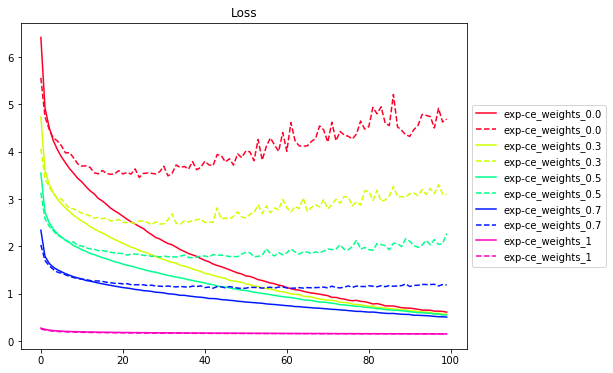

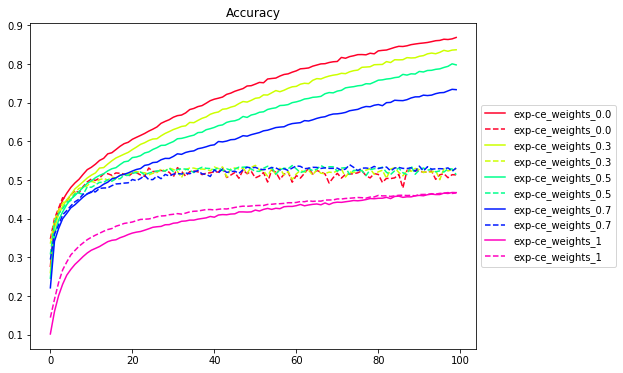

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()